# ENN583 - Week 3 - Practical: Stereo Vision    

In this week's Prac we will explore two stereo vision algorithms available in OpenCV. 

We will again work with the -- now familiar -- Kitti dataset.



## Load the Kitti Sequence

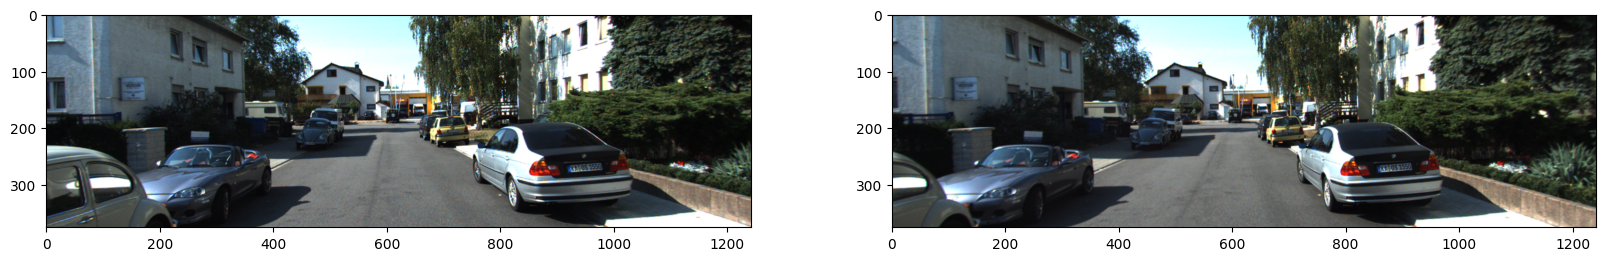

In [2]:
# Check if pykitti is installed, if not use pip to set it up
try:
    import pykitti
except:
    !pip install pykitti
    import pykitti

# Read the dataset sequence we just downloaded
basedir = '../kitti'
date = '2011_09_26'
drive = '0035'

# The 'frames' argument is optional - default: None, which loads the whole dataset.
# data = pykitti.raw(basedir, date, drive, frames=range(0, 50, 5))
data = pykitti.raw(basedir, date, drive)


import cv2
from matplotlib import pyplot as plt
import numpy as np

# get the left and right stereo images from the 10th frame
left, right = data.get_rgb(10)
left = np.array(left)
right = np.array(right)

# use plt to show them side by side
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.show()


## Use the Stereo Block Matcher
The simplest stereo matching algorithm is provided by the `StereoBM` class in OpenCV. The cell below demonstrated how to use it.

Notice that it expects the left and right image to be grey scale images, so we will have to convert the RBB images first.

You can access the documentation of the `StereoBM` here: https://docs.opencv.org/4.7.0/d9/dba/classcv_1_1StereoBM.html

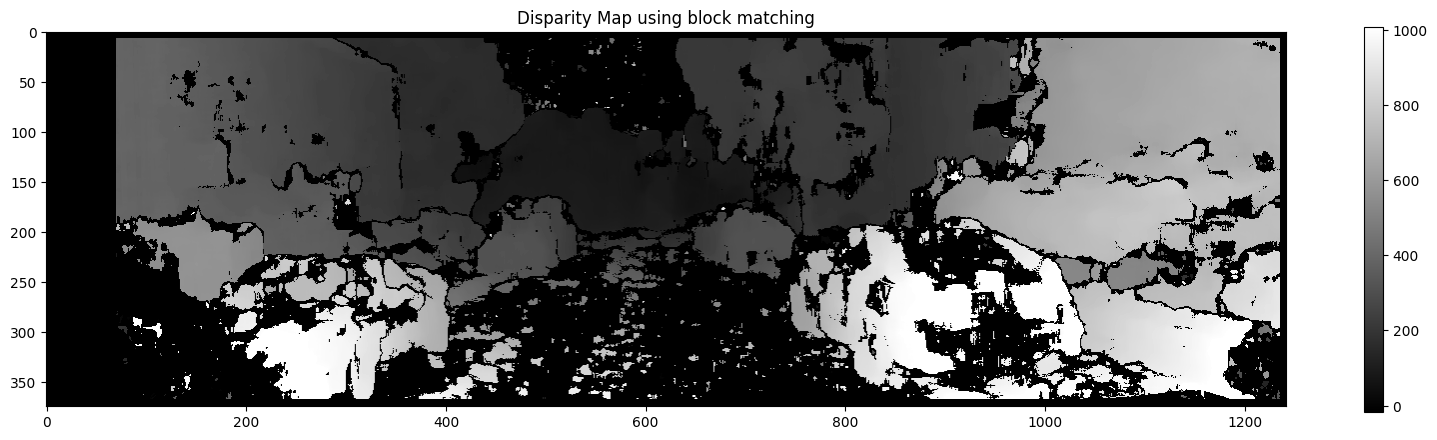

Disparity range:  -16  to  1008


In [3]:
# load images and convert to grayscale
left, right = data.get_rgb(10)
left = cv2.cvtColor(np.array(left), cv2.COLOR_BGR2GRAY)
right = cv2.cvtColor(np.array(right), cv2.COLOR_BGR2GRAY)

# use the stereo blockmatcher to get a disparity map
stereo = cv2.StereoBM_create(blockSize=15) # this creates the blockmatcher object
disparity = stereo.compute(left, right)                     # this computes the disparity map

# display the disparity
plt.figure(figsize=(20,5))
plt.imshow(disparity,'gray')
plt.title('Disparity Map using block matching')
plt.colorbar()
plt.show()

# what is the range of disparity values?
print('Disparity range: ', disparity.min(), ' to ', disparity.max())



Notice how the disparity values range from below -16 to over 1000! We know that they should be in pixels, so what is going on here?

OpenCV returns the disparity map scaled by 16, and as a int16 type. To get the real disparity values, we will have to scale it accordingly.


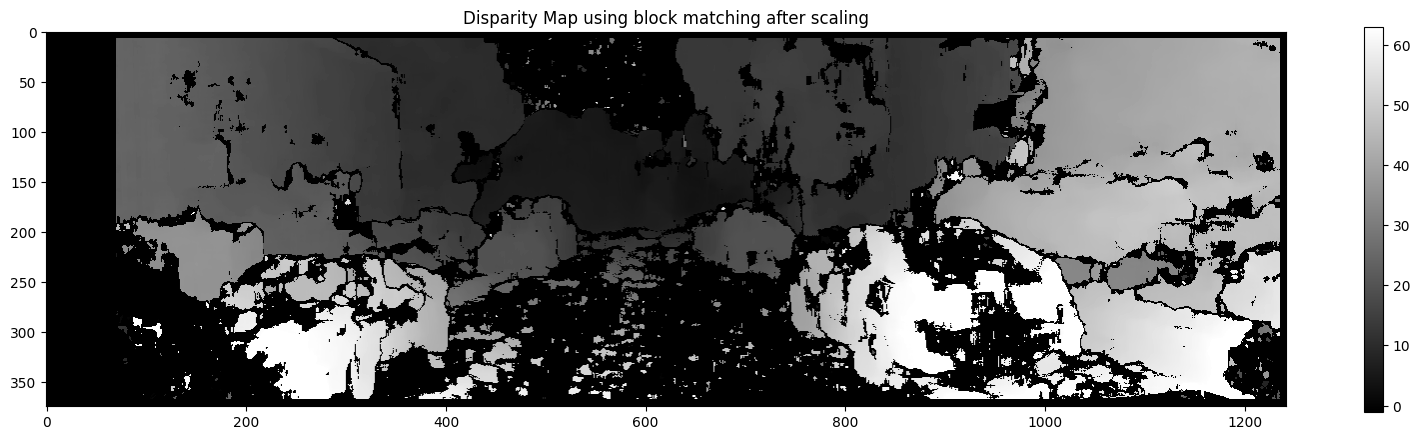

Scaled disparity range:  -1.0  to  63.0


In [4]:
# scale the values in `disparity` to pixels
if disparity.dtype != np.float32:
    disparity = disparity.astype(np.float32) / 16.0

# display the disparity
plt.figure(figsize=(20,5))
plt.imshow(disparity,'gray')
plt.title('Disparity Map using block matching after scaling')
plt.colorbar()
plt.show()

# what is the range of disparity values?
print('Scaled disparity range: ', disparity.min(), ' to ', disparity.max())

That looks much better! Now we have the disparity values in pixels. 

Notice how a negative value of -1 is used to indicate pixels for which no disparity value could be found.

### Your Turn!
Let's explore some parameters of the block matcher.

In the cell below, create the stereo matcher with different parameters settings and display the resulting disparity images side by side for better comparison.

Change the following paramters:

 - `blockSize` 
   - Try different block sizes between 5 and 25. 
   - Notice that this parameter must be an odd number. Why is that?
   - What can you observe as you make the block size smaller or larger?
- Uniqueness Ratio
  - This is a post processing sep, that filters out pixels with potentially bad disparity estimates.
    - A pixel is filtered out if the best matching disparity is not sufficiently better than every other disparity in the search range, by applying a uniqueness ratio test.
  - Try changingn this value between 15 and 100, by calling `stereo.setUniquenessRatio()`
  - You can see what the current value is with `stereo.getUniquenessRatio()`
- Texture Threshold
  - This filters out areas that do not have enough texture information for reliable matching.
  - You can access it via the functions `stereo.getTextureThreshold()` and `stereo.setTextureThreshold()`

Scaled disparity range:  -1.0  to  63.0


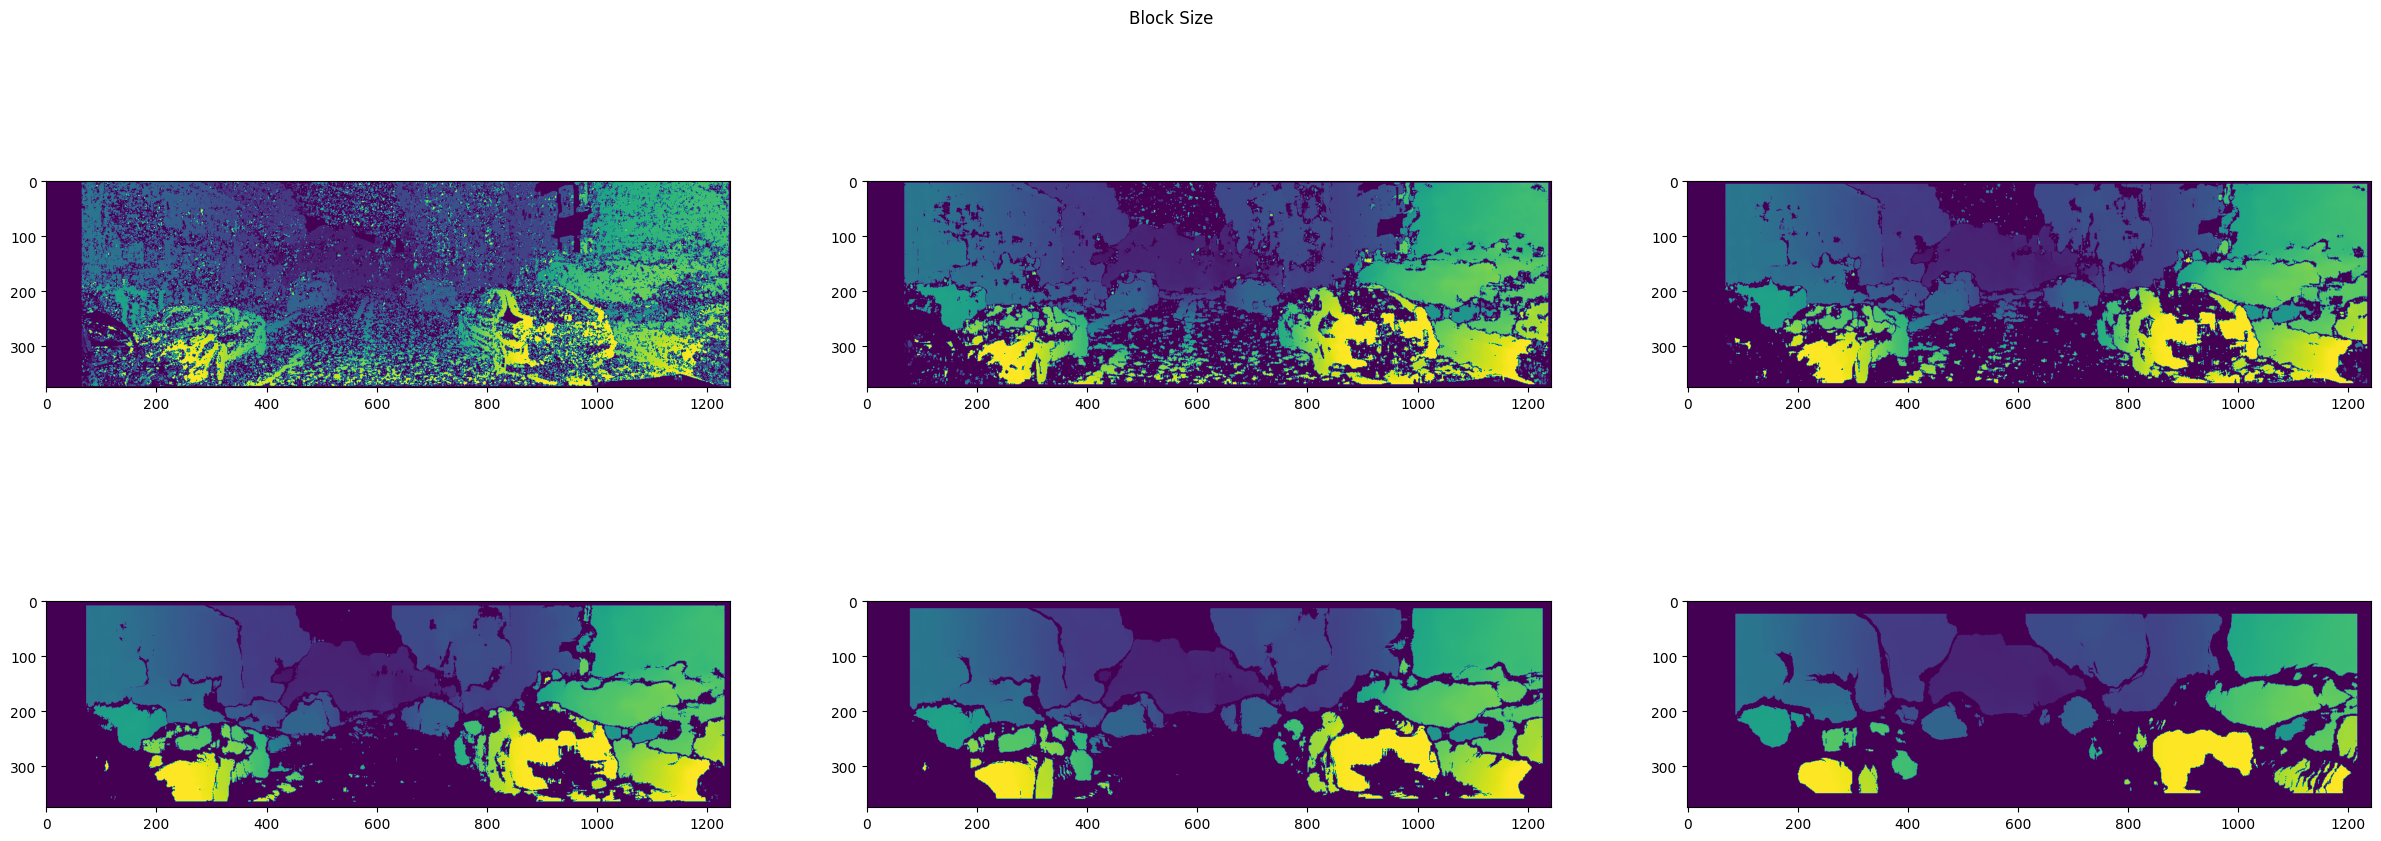

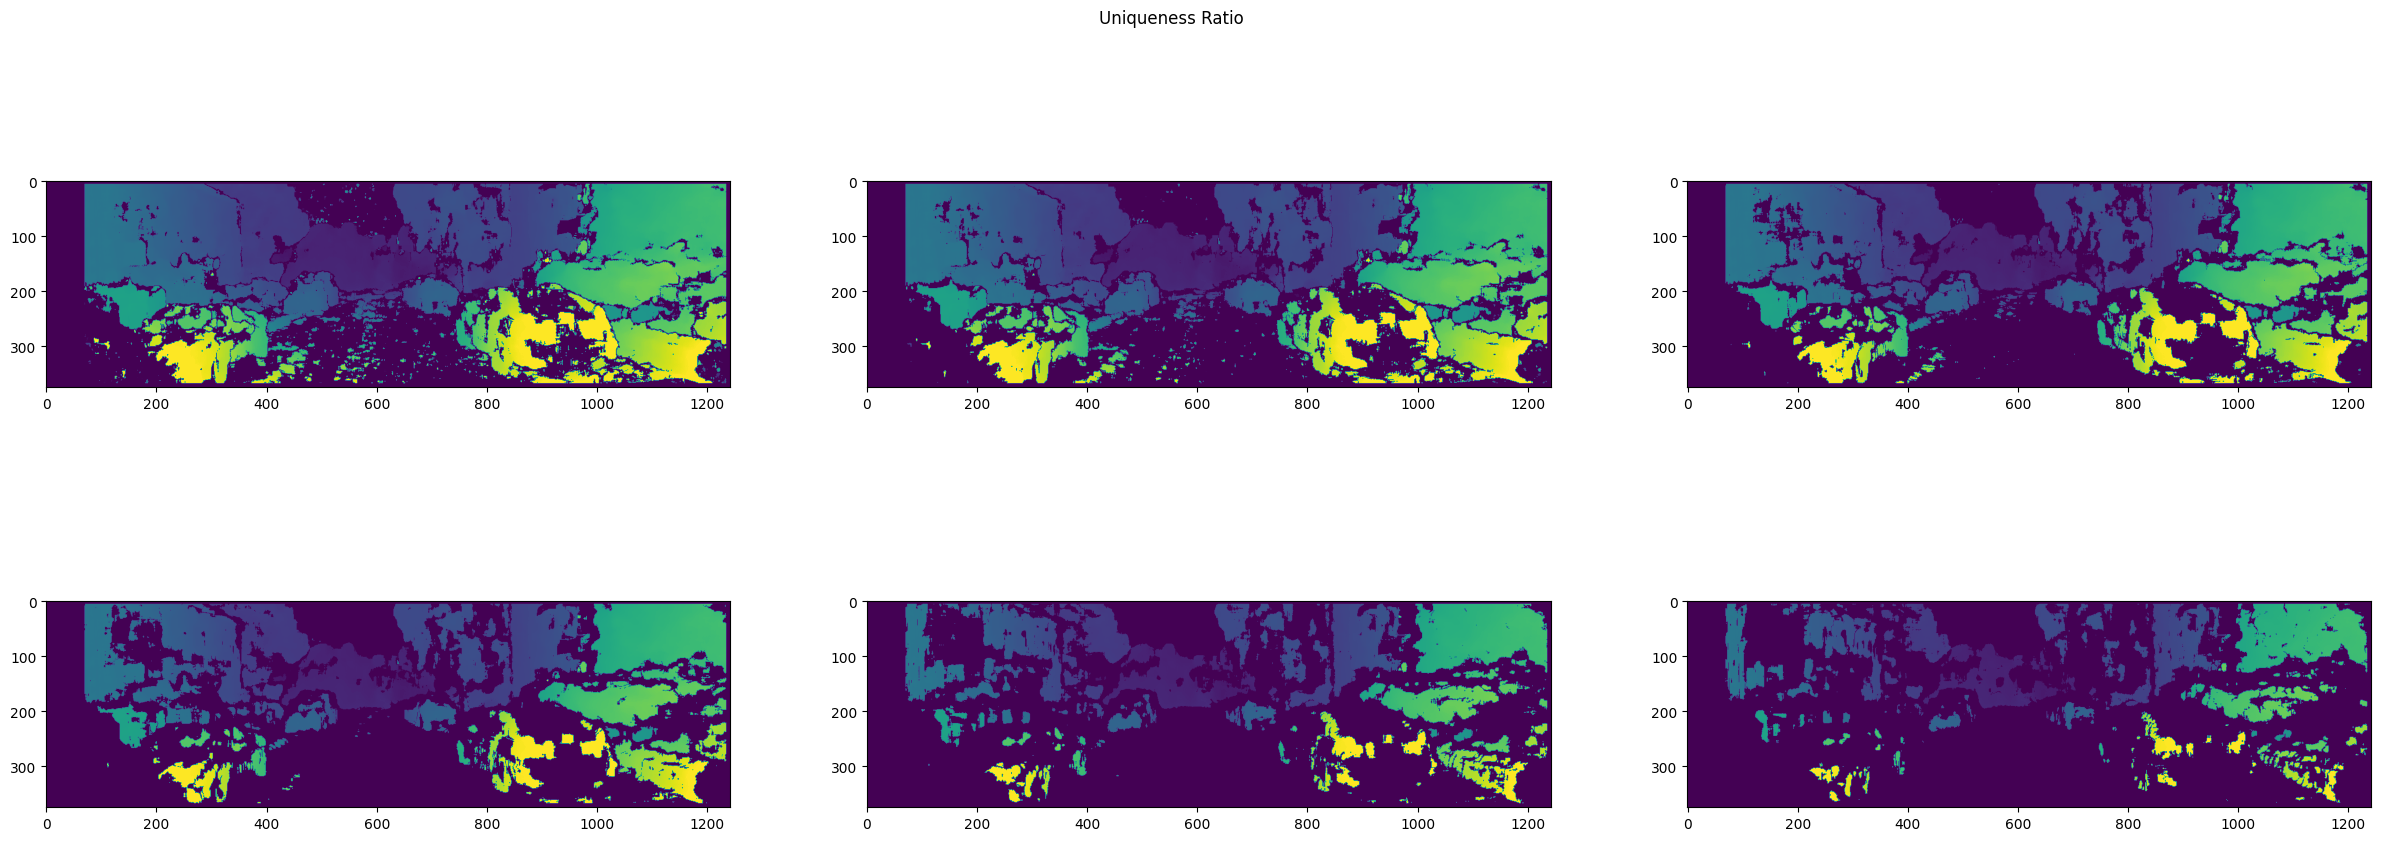

In [5]:
# load images and convert to grayscale
left, right = data.get_rgb(10)
left = cv2.cvtColor(np.array(left), cv2.COLOR_BGR2GRAY)
right = cv2.cvtColor(np.array(right), cv2.COLOR_BGR2GRAY)

# YOUR TURN! Change the parameters of the blockmatcher and compare the results

# use the stereo blockmatcher to get a disparity map
def get_bm_disparity(block_size=15, uniqueness_ratio=None):
    stereo = cv2.StereoBM_create(blockSize=block_size) # try changing the blockSize
    if uniqueness_ratio is not None:
        stereo.setUniquenessRatio(uniqueness_ratio)
    disparity = stereo.compute(left, right)  

    # scale the disparity to proper pixel values
    disparity = disparity.astype(np.float32) / 16.0
    return disparity

def plot_disparity(disparity, title=''):
    if type(disparity) == list:
        images = disparity
        '''Plot a grid of images'''
        factors = [i for i in range(1, len(images)+1) if len(images) % i == 0]
        ncols = factors[len(factors) // 2] if len(factors) else len(images) // 4 + 1
        nrows = int(len(images) / ncols) + int(len(images) % ncols)
        imgs = [images[i] if len(images) > i else None for i in range(nrows * ncols)]
        f, axes = plt.subplots(nrows, ncols, figsize=(10*ncols, 5*nrows))
        axes = axes.flatten()[:len(imgs)]
        for img, ax in zip(imgs, axes.flatten()): 
            if np.any(img):
                if len(img.shape) > 2 and img.shape[2] == 1:
                    img = img.squeeze()
                ax.imshow(img)
        plt.suptitle(title)
        
    else:
        # plot the disparity map
        plt.figure(figsize=(20,5))
        plt.imshow(disparity,'gray')
        plt.title('Disparity Map using block matching')
        plt.colorbar()
        plt.show()

# block size
block_sizes = [5,11,15,21,31,51]
disparities = [get_bm_disparity(block_size=bs) for bs in block_sizes]
plot_disparity(disparities, title='Block Size')

# uniqueness ratio
uniques = [15,20,30,50,75,100]
disparities = [get_bm_disparity(uniqueness_ratio=ur) for ur in uniques]
plot_disparity(disparities, title='Uniqueness Ratio')


# what is the range of disparity values?
print('Scaled disparity range: ', disparity.min(), ' to ', disparity.max())

## Try the Semi-Global Matching
OpenCV comes with a second implementation for stereo matching, based on the paper 
`Heiko Hirschmuller. Stereo processing by semiglobal matching and mutual information. Pattern Analysis and Machine Intelligence, IEEE Transactions on, 30(2):328–341, 2008.` which is available here: https://core.ac.uk/download/pdf/11134866.pdf

This is a more advanced method compared to the simple block matchers, but can be more resource hungry.

The OpenCV documentation is at https://docs.opencv.org/4.7.0/d2/d85/classcv_1_1StereoSGBM.html

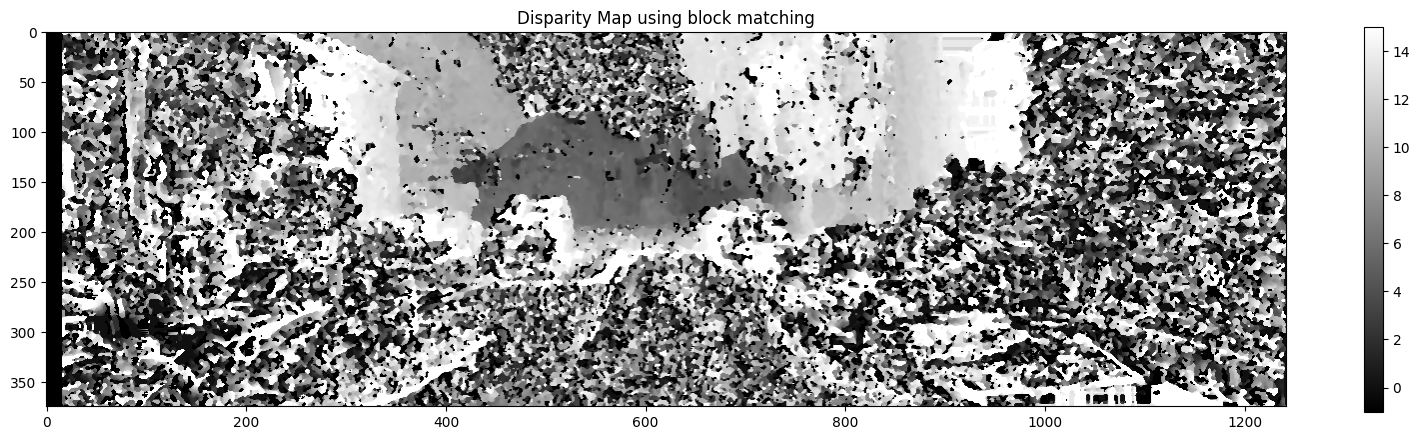

Scaled disparity range:  -1.0  to  15.0


In [6]:
# Load the images. This time we do not have to convert them to grayscale, since the algorithm can work directly on RGB
left, right = data.get_rgb(10)
left = np.array(left)
right = np.array(right)

# create the Semi-Global Block Matching object
stereo = cv2.StereoSGBM_create(blockSize=5, numDisparities=16, mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)

# compute the disparity map
disparity = stereo.compute(left, right)

# as before, we have to scale the outputs to actual pixel values
disparity = disparity.astype(np.float32) / 16.0

# display the disparity
plot_disparity(disparity, title='Disparity Map using Semi-Global Matching after scaling')

# what is the range of disparity values?
print('Scaled disparity range: ', disparity.min(), ' to ', disparity.max())

### Your Turn!

The SGBM is better documented than the simple BM class. Head to https://docs.opencv.org/4.7.0/d2/d85/classcv_1_1StereoSGBM.html#adb7a50ef5f200ad9559e9b0e976cfa59 and check the parameters that can be passed into the constructor. 

Run a number of experiments comparing the effects of these parameters.

Definitely try changing `blockSize` and `numDisparities`, as well as `uniquenessRatio`, `P1` and `P2` (controlling the smoothness).

If you set `numDisparities` to a low value (try comparing between 16 and 100), what do you notice? Why do you think this happens?

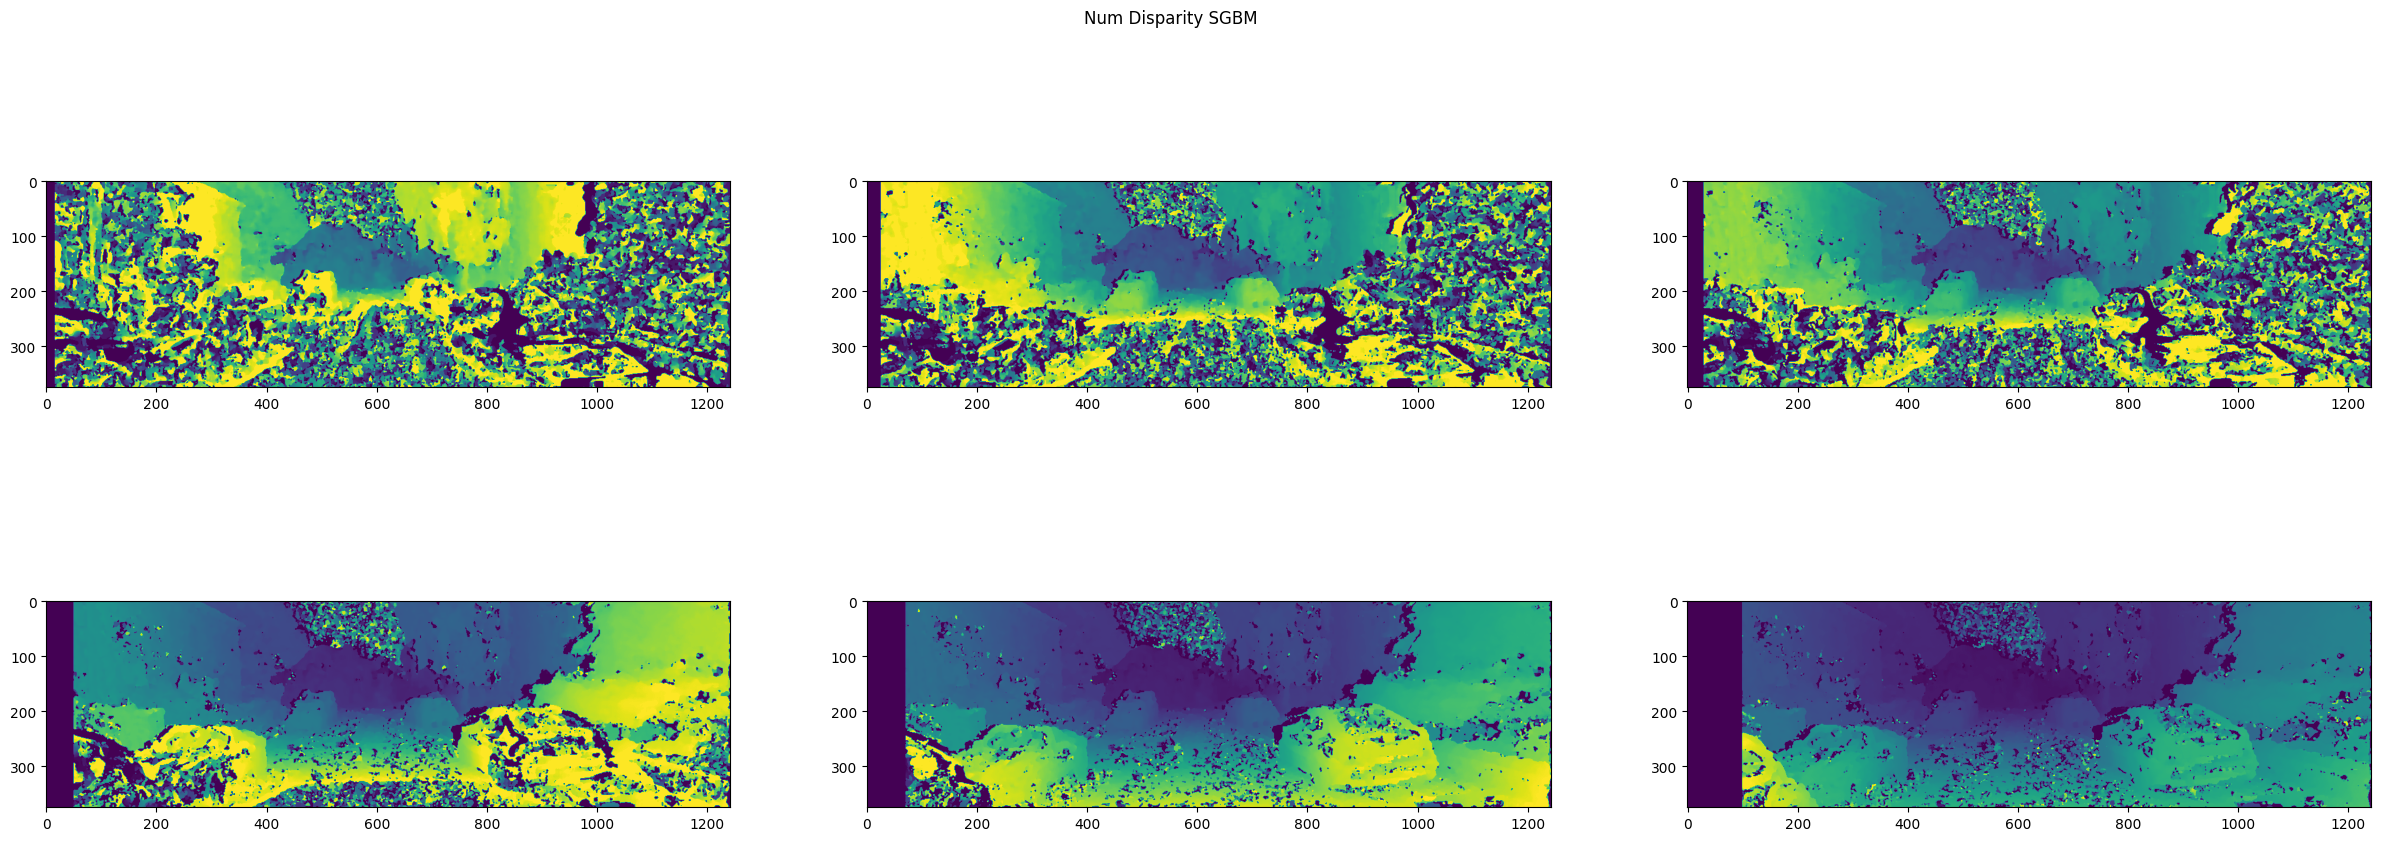

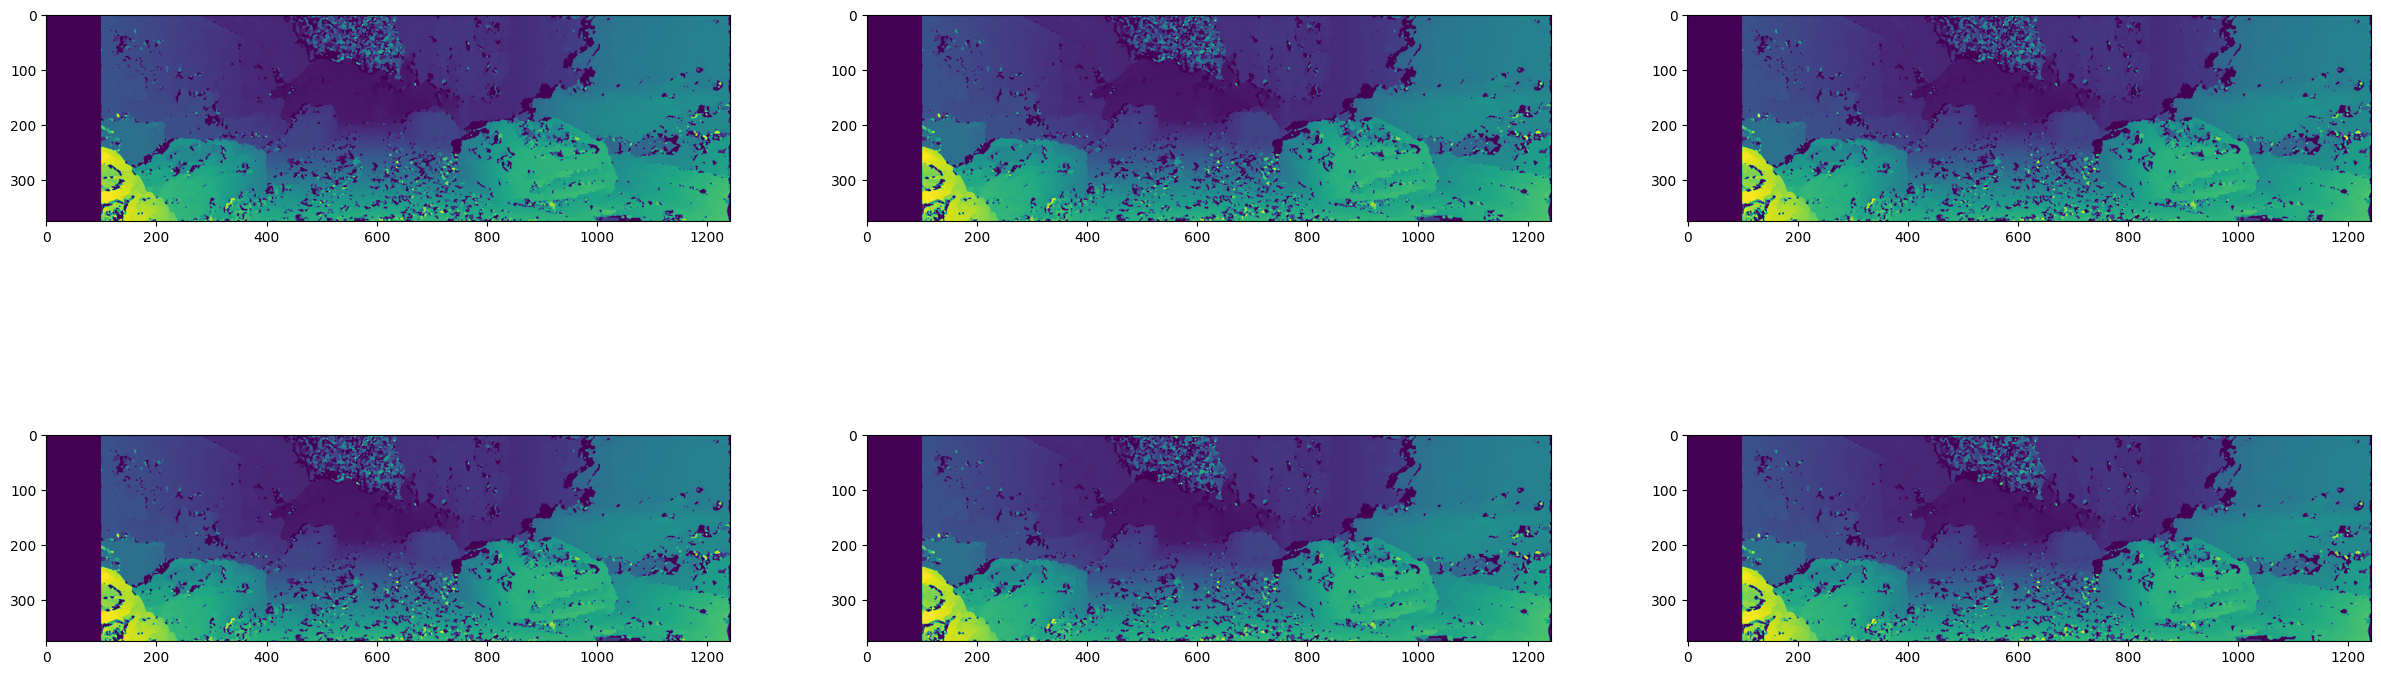

In [7]:
# Your Turn!
def get_sgbm_disparity(block_size=9, uniqueness_ratio=None, num_disparities=100,
                       p1=None, p2=None):
    if p1 is not None:
        stereo = cv2.StereoSGBM_create(blockSize=block_size, 
                                    numDisparities=num_disparities, P1=p1, P2=p2) # try changing the blockSize
    else:
        stereo = cv2.StereoSGBM_create(blockSize=block_size, 
                                    numDisparities=num_disparities) # try changing the blockSize
    if uniqueness_ratio is not None:
        stereo.setUniquenessRatio(uniqueness_ratio)
        
    disparity = stereo.compute(left, right)  

    # scale the disparity to proper pixel values
    disparity = disparity.astype(np.float32) / 16.0
    return disparity

# num disparity
num_disps = [16,25,30,50,70,100]
disparities = [get_sgbm_disparity(num_disparities=nd) for nd in num_disps]
plot_disparity(disparities, title='Num Disparity SGBM')

# p1, p2
p1p2_val = [(5,10), (1,10), (10, 20), (10, 15), (10, 100), (50, 100)]
disparities = [get_sgbm_disparity(p1=p1, p2=p2) for p1, p2 in p1p2_val]
plot_disparity(disparities)

## Calculate 3D coordinates for Interest Points

We now have two different ways of establishing the 3D coordinates for points in the image. 

**Option 1:**
 - We can calculate the full disparity map and use that to calculate the 3D coordiantes for specific interest points that we find in either the left or right image.


**Option 2:**
 - We can detect interest points in both the left and right image, then match between the left and right points. We then have a "sparse" disparity map, meaning we only have disparity information for the matched interest points. This can be used to calculate their 3D coordinates.

### Your Turn!
Implement both options and compare the results.

[[-1.     -1.     -1.     ... 43.3125 54.0625 54.3125]
 [-1.     -1.     -1.     ... 43.1875 43.1875 -1.    ]
 [-1.     -1.     -1.     ... 43.1875  0.     -1.    ]
 ...
 [-1.     -1.     -1.     ... 40.125   0.      0.    ]
 [-1.     -1.     -1.     ... 71.625   0.      0.    ]
 [-1.     -1.     -1.     ... 71.625  26.      0.    ]]


/tmp/ipykernel_30364/1613345275.py:17: RuntimeWarning: divide by zero encountered in divide
  Z_p = b*f / disparity.astype(np.float32)


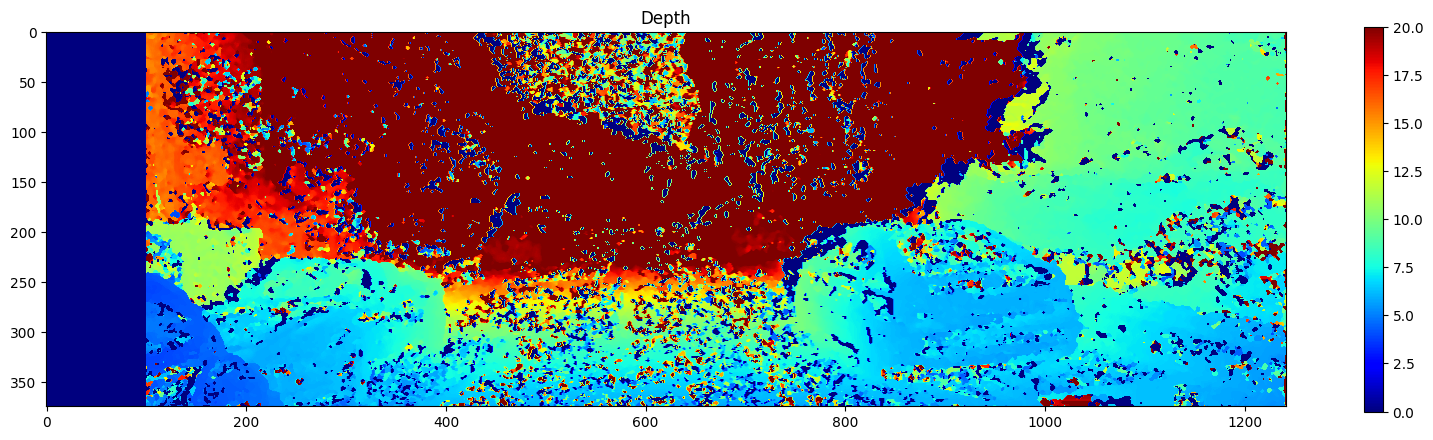

In [8]:
# ====== OPTION 1 ======

# load images
left, right = data.get_rgb(10)
left = np.array(left)
right = np.array(right)

# claculate disparity map
disparity = get_sgbm_disparity(block_size=5, num_disparities=100, p1=10, p2=21)
print(disparity)
# find interest points in left image


# calculate 3D coordinates of interest points based on disparity map
b = data.calib.b_rgb
f = data.calib.P_rect_20[0][0]
Z_p = b*f / disparity.astype(np.float32)
depth = Z_p.clip(0,20)

plt.figure(figsize=(20,5))
plt.imshow(depth, 'jet')
plt.title('Depth')
plt.colorbar()
plt.show()

# ====== OPTION 2 ======

# load images

# find interest points (and their descriptors) in left and right image

# match interest points between left and right image

# use difference in v-coordinates of matched interest points to calculate sparse disparity map

# calculate 3D coordinates of interest points 


# ====== Comparison ======

# Are the results of the two options the same? 

# If not, what reasons do you suspect?
